In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Check for CUDA availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Custom Evaluation Metrics
def mean_squared_error_manual(y_true, y_pred):
    """Calculates Mean Squared Error using NumPy."""
    return np.mean((y_true - y_pred)**2)

def r2_score_manual(y_true, y_pred):
    """Calculates R-squared (coefficient of determination) using NumPy."""
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

In [4]:
# Differential Equation and Analytical Solution

def cooling_law(time, Tenv, T0, R):
    """Analytical solution to Newton's law of cooling."""
    return Tenv + (T0 - Tenv) * np.exp(-R * time)

def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

In [5]:
# Neural Network Definition 

class Net(nn.Module):
    """A simple fully-connected neural network."""
    def __init__(self, input_dim, output_dim, n_units=100):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
# Data Setup 
# Parameters for the cooling law
Tenv = 25
T0 = 100
R = 0.005

# Time points for generating training data and for prediction
t_train = np.linspace(0, 300, 10).reshape(-1, 1)
T_train = cooling_law(t_train, Tenv, T0, R) + 2 * np.random.randn(10, 1)
t_pred = np.linspace(0, 1000, 1000).reshape(-1, 1)
T_analytical = cooling_law(t_pred, Tenv, T0, R)

In [7]:
# Convert numpy arrays to torch tensors
t_train_torch = torch.from_numpy(t_train).float().to(DEVICE)
T_train_torch = torch.from_numpy(T_train).float().to(DEVICE)
t_pred_torch = torch.from_numpy(t_pred).float().to(DEVICE)
t_physics = torch.linspace(0, 1000, 100, requires_grad=True).reshape(-1, 1).to(DEVICE)

In [8]:
# Physics-Informed Loss Function 

def physics_loss(model):
    """Calculates the physics-informed loss."""
    temps = model(t_physics)
    dT = grad(temps, t_physics)[0]
    pde = R * (Tenv - temps) - dT
    return torch.mean(pde**2)

In [9]:
# Training 

# Instantiate the network and optimizer
net = Net(1, 1).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [10]:
# Training loop
epochs = 30000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()

    # Data loss
    T_pred_train = net(t_train_torch)
    loss_data = criterion(T_pred_train, T_train_torch)

    # Physics loss
    loss_phys = physics_loss(net)

    # Total loss
    loss = loss_data + 1.0 * loss_phys
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

C:\Users\Rishabh Kumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/30000, Loss: 5758.1870
Epoch 2000/30000, Loss: 554.2520
Epoch 4000/30000, Loss: 3.4860
Epoch 6000/30000, Loss: 3.2415
Epoch 8000/30000, Loss: 3.2340
Epoch 10000/30000, Loss: 3.2255
Epoch 12000/30000, Loss: 3.2148
Epoch 14000/30000, Loss: 3.4727
Epoch 16000/30000, Loss: 3.3612
Epoch 18000/30000, Loss: 3.2143
Epoch 20000/30000, Loss: 3.2075
Epoch 22000/30000, Loss: 3.2073
Epoch 24000/30000, Loss: 3.2102
Epoch 26000/30000, Loss: 3.2077
Epoch 28000/30000, Loss: 3.2243


In [11]:
# Prediction and Visualization 

# Get predictions from the trained model
T_pred = net(t_pred_torch).detach().cpu().numpy()

# Evaluation Metrics 
mse_final = mean_squared_error_manual(T_analytical, T_pred)
r2_final = r2_score_manual(T_analytical, T_pred)

print(f"\n--- Model Evaluation ---")
print(f"Final Mean Squared Error on the full domain: {mse_final:.6f}")
print(f"R-squared (R²) Score: {r2_final:.6f}")
print("------------------------")


--- Model Evaluation ---
Final Mean Squared Error on the full domain: 1.034903
R-squared (R²) Score: 0.996975
------------------------


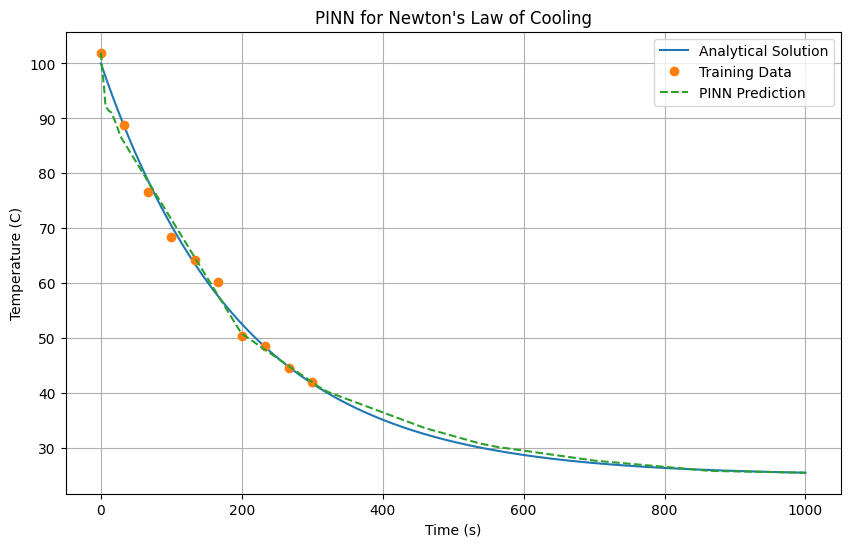

In [12]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t_pred, T_analytical, label='Analytical Solution')
plt.plot(t_train, T_train, 'o', label='Training Data')
plt.plot(t_pred, T_pred, '--', label='PINN Prediction')
plt.title('PINN for Newton\'s Law of Cooling')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

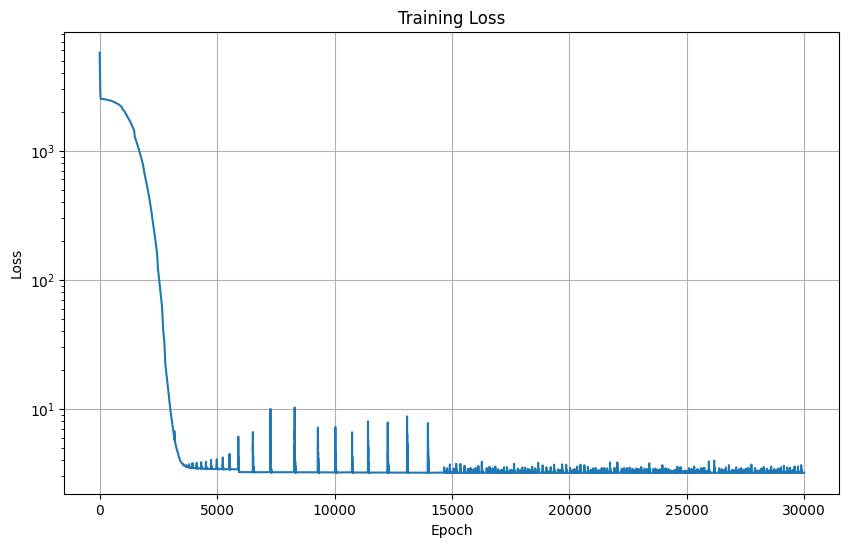

In [14]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.yscale('log')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()